# Car Data Analysis

## 1. Introduction

In this project, I will determine what influences and drives the car prices (MSRP, Manufacturer’s Suggested Retail Price) given its technical specs. Specifically, I will demonstrate which car(s) is/are the most under/overpriced one(s).

The target variable is continuous, so it is reasonable to use regression models. Besides, in this case, I focus on the factors influencing car prices, so interpretability is important. In the project, I will perform data cleaning and preliminary data visualisation first, fit several base models with good interpretability, conduct hyperparameter tuning, interpret the model, and explain some cases from the prediction as well as demonstrate the cars I believe to be most under/overpriced. In the end, I will further discuss the effect of the brand.

> All the assumptions I took in the project:
>
> 1. The effect of the brand is small so I don't have to include the variable related to the brand.
> 2. The imputation method is robust.
> 3. Except for the variables in the dataset, there are no other variables determining the price of a car, including promotion, and pricing strategy.

In [1]:
# import the required packages
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# import the auxiliary function
from collections import Counter

# import statistical testing functions
import scipy.stats as stats

# import machine learning related functions
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('car_data_cleaned.csv', index_col=[0]) # read the data

In [3]:
df.head()

,Car_Make_Model_Style,MSRP,Style Name,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,EPA Classification,Base Curb Weight (lbs),Front Hip Room (in),...,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year
0,2019 Acura RDX Specs: FWD w/Technology Pkg,40600.0,FWD w/Technology Pkg,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3790.0,55.0,...,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
1,2019 Acura RDX Specs: FWD w/Advance Pkg,45500.0,FWD w/Advance Pkg,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3829.0,55.0,...,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
2,2019 Acura RDX Specs: FWD w/A-Spec Pkg,43600.0,FWD w/A-Spec Pkg,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3821.0,55.0,...,2.0,122.0,255.0,255.0,20.0,20.0,1.0,1.0,4.0,2019.0
3,2019 Acura RDX Specs: FWD,37400.0,FWD,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3783.0,55.0,...,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
4,2019 Acura RDX Specs: AWD w/Technology Pkg,42600.0,AWD w/Technology Pkg,All Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 4WD,4026.0,55.0,...,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0


## 2. Data Cleaning

In this section, I will work on several things,

* Drop the unnecessary columns
* Tidy the categorical variables
* Set the correct data types

Among all featuers, it is difficult to know the meaning of `Other Features`, so I worked on this first.

In [4]:
f_list = None

# the values are separated by \r, I split all of them to get a list containing all features from that column
for i in df['Other Features'].str.split('\r'):
    if f_list == None:
        f_list = list(i)
    else:
        f_list += list(i)

In [5]:
len(f_list)

141752

There are 141752 items in the column, now checking on the 20 most common features.

In [6]:
Counter(f_list).most_common(20)

[('\nSide Impact Beams', 9583),
 ('\nDual Stage Driver And Passenger Seat-Mounted Side Airbags', 9260),
 ('\nDual Stage Driver And Passenger Front Airbags', 9228),
 ('\nABS And Driveline Traction Control', 9131),
 ('\nAirbag Occupancy Sensor', 9057),
 ('\nOutboard Front Lap And Shoulder Safety Belts -inc: Rear Center 3...',
  7298),
 ('\nRear Child Safety Locks', 6416),
 ('Electronic Stability Control (ESC)', 6170),
 ('\nCurtain 1st And 2nd Row Airbags', 6089),
 ('\nBack-Up Camera', 4838),
 ('\nTire Specific Low Tire Pressure Warning', 4798),
 ('\nLow Tire Pressure Warning', 4578),
 ('\nDriver Knee Airbag', 1484),
 ('\nDriver And Passenger Knee Airbag', 1429),
 ('\nOutboard Front Lap And Shoulder Safety Belts -inc: Height...', 1303),
 ('\nFront And Rear Parking Sensors', 1225),
 ('Electronic Stability Control (ESC) And Roll Stability Control...', 1215),
 ('\nRear Parking Sensors', 957),
 ('\nOutboard Front Lap And Shoulder Safety Belts -inc: Pretensioners', 918),
 ('\nMykey System -inc

Many common `other features` are overlapped with the other variables in the model, such as the features related to airbags, child safety rear door locks, ABS, stability control, back-up camera, tire pressure monitor, parking aid, and so on. So to simplify the data, I will drop this column.

Given different data types, the methods of preprocessing are different. The list below is the methods summary I will use to process the data after checking the data.

Consider all variables,

#### Response Variable
* MSRP: the response variable, only keep the data without NA

#### Unnecessary Variables (Drop the Variables)
> Assumption:
>
>In this project, I only looked at the technical specs, hence I assumed that the effect of the brand is small and I don't have to include the variable related to the brand.

* Car_Make_Model_Style: do not consider (assumption), drop      
* Style Name: do not consider (assumption), drop
* EPA Classification: because it is similar to `Body Style` and contains lots of NA values, I dropped this one and keep `Body Style` instead 
* Basic Miles/km: not related to technical specs, drop               
* Basic Years: not related to technical specs, drop                        
* Corrosion Miles/km: not related to technical specs, drop              
* Corrosion Years: not related to technical specs, drop               
* Drivetrain Miles/km: not related to technical specs, drop            
* Drivetrain Years: not related to technical specs, drop                
* Roadside Assistance Miles/km: not related to technical specs, drop 
* Roadside Assistance Years: not related to technical specs, drop
* Other Features: duplicated with other columns, to drop 

#### Categorical Variables (Set to Categorical Variables)
* Drivetrain: to categorical
* Body Style: to categorical 
* Air Bag-Frontal-Driver: to categorical
* Air Bag-Frontal-Passenger: to categorical
* Air Bag-Passenger Switch (On/Off): to categorical
* Air Bag-Side Body-Front: to categorical
* Air Bag-Side Body-Rear: to categorical
* Air Bag-Side Head-Front: to categorical
* Air Bag-Side Head-Rear: to categorical
* Brakes-ABS: to categorical
* Child Safety Rear Door Locks: to categorical
* Daytime Running Lights: to categorical
* Traction Control: to categorical
* Night Vision: to categorical
* Rollover Protection Bars: to categorical
* Fog Lamps: to categorical
* Parking Aid: to categorical
* Tire Pressure Monitor: to categorical
* Back-Up Camera: to categorical
* Stability Control: to categorical
* Engine Configuration: to categorical             
* Engine Class: to categorical
* Year: to categorical

#### Categorical Variables (Simplify the Categories and Set to Categorical Variables)
* Fuel System: some duplicated types, need to be cleaned 
* Steering Type: some duplicated types, need to be cleaned
* Suspension Type - Front: some duplicated types, need to be cleaned      
* Suspension Type - Rear: some duplicated types, need to be cleaned

#### Numerical Variables (Keep Original)
* Passenger Capacity     
* Passenger Doors             
* Base Curb Weight (lbs)             
* Front Hip Room (in)                
* Front Leg Room (in)                
* Second Shoulder Room (in)          
* Passenger Volume                   
* Second Head Room (in)              
* Front Shoulder Room (in)           
* Second Hip Room (in)               
* Front Head Room (in)               
* Second Leg Room (in)               
* Wheelbase (in)                     
* Track Width, Front (in)            
* Width, Max w/o mirrors (in)        
* Track Width, Rear (in)             
* Height, Overall (in)               
* Fuel Tank Capacity, Approx (gal)   
* Fuel Economy Est-Combined (MPG)    
* EPA Fuel Economy Est - City (MPG)  
* EPA Fuel Economy Est - Hwy (MPG)       
* First Gear Ratio (:1)              
* Fourth Gear Ratio (:1)             
* Second Gear Ratio (:1)             
* Reverse Ratio (:1)                 
* Fifth Gear Ratio (:1)              
* Trans Type                         
* Third Gear Ratio (:1)              
* Final Drive Axle Ratio (:1)        
* Turning Diameter - Curb to Curb    
* Front Wheel Material
* Maximum Alternator Capacity (amps) 
* Gears                              
* Net Horsepower                     
* Net Horsepower RPM                 
* Net Torque                         
* Net Torque RPM                     
* Displacement (L)                   
* Displacement (cc)                  
* Rear Tire Width                    
* Front Tire Width                   
* Rear Wheel Size                    
* Front Wheel Size                   
* Tire Width Ratio                   
* Wheel Size Ratio                   
* Tire Ratio                                                        

Here I summarised variables to 4 groups for different preprocessing procedures.

In [7]:
to_drop = ['Car_Make_Model_Style', 'Style Name', 'EPA Classification', 'Other Features',
           'Basic Miles/km','Basic Years','Corrosion Miles/km','Corrosion Years','Drivetrain Miles/km',
           'Drivetrain Years','Roadside Assistance Miles/km' ,'Roadside Assistance Years']
to_cat = ['Drivetrain', 'Body Style', 'Engine Configuration', 'Engine Class',
          'Front Wheel Material','Air Bag-Frontal-Driver','Air Bag-Frontal-Passenger', 
          'Air Bag-Passenger Switch (On/Off)','Air Bag-Side Body-Front','Air Bag-Side Body-Rear',
          'Air Bag-Side Head-Front','Air Bag-Side Head-Rear',
          'Brakes-ABS','Child Safety Rear Door Locks','Daytime Running Lights','Traction Control',
          'Night Vision','Rollover Protection Bars','Fog Lamps','Parking Aid','Tire Pressure Monitor',
          'Back-Up Camera','Stability Control']
to_dup = ['Fuel System', 'Steering Type', 'Suspension Type - Front', 'Suspension Type - Rear']
to_drop_na = ['MSRP']

In [8]:
df1 = df.drop(to_drop, axis=1) # drop the unnecessary variables

In [9]:
df1.dropna(subset=to_drop_na, axis=0, inplace=True) # drop the data with NA values in MSRP

In [10]:
df1[to_cat] = df1[to_cat].astype('category') # set the data type to category

In [11]:
for i in to_dup: # check the unique values for the variables which needing to be simplified
    print(i, df1[i].unique())

Fuel System ['Gasoline Direct Injection' 'Sequential MPI' 'Port/Direct Injection'
 'MPI' 'Diesel Direct Injection' nan 'Sequential MPI (injection)'
 'Electronic Fuel Injection' 'Electronic fuel injection'
 'Direct Injection' 'SIDI' 'DI' 'Hydrogen']
Steering Type ['Rack-Pinion' 'Pwr Rack & Pinion' 'Pwr' 'Electric Rack & Pinion' nan
 'Electric Rack-&-Pinion' 'Electric Power Steering'
 '4-Wheel Pwr Rack & Pinion' 'Electric Variable-Effort Power'
 'Electric Pwr' 'Pwr Rack-&-Pinion' 'Electric' 'Electric Pwr Steering'
 'Re-Circulating Ball' 'Pwr Electric Assist']
Suspension Type - Front ['Strut' 'Double Wishbone' 'Multi-Link' 'MacPherson Strut'
 'Independent MacPherson Strut' 'HiPer Strut' 'HiPer strut'
 'MacPherson strut' 'HiPER strut' 'Independent' 'Short/Long Arm'
 'Independent SLA' nan 'Magnetic Ride Control' 'Coil-Over Strut'
 'Coil springs' 'Coil Spring' 'Torsion Bar' 'Short And Long Arm' 'Other'
 'Coil Over Strut' 'Coil-Over Shock' 'Independent Coil' 'Leading Link'
 'Double Wishbone P

To simplify the categories for these four variables, I refered the data below,

[1] Fuel System: https://autoportal.com/articles/what-is-gdi-fsi-cgi-sidi-direct-injection-6965.html

[2] Steering Type: https://steeringly.com/rack-and-pinion-system-vs-power-steering-system-what-are-the-differences/

[3] Suspension Type: https://www.caranddriver.com/news/a15340751/explained-the-five-most-common-automotive-suspensions/

In [12]:
# grouping the similar system/type to simplify the categories

df1.loc[df1['Fuel System'] == 'Sequential MPI (injection)','Fuel System'] = 'Sequential MPI'
df1.loc[df1['Fuel System'] == 'Gasoline Direct Injection','Fuel System'] = 'DI'
df1.loc[df1['Fuel System'] == 'Diesel Direct Injection','Fuel System'] = 'DI'
df1.loc[df1['Fuel System'] == 'Direct Injection','Fuel System'] = 'DI'
df1.loc[df1['Fuel System'] == 'Electronic fuel injection','Fuel System'] = 'Electronic Fuel Injection'

df1.loc[df1['Steering Type'] == 'Rack-Pinion','Steering Type'] = 'Rack & Pinion'
df1.loc[df1['Steering Type'] == 'Electric Rack-&-Pinion','Steering Type'] = 'Electric Rack & Pinion'
df1.loc[df1['Steering Type'] == '4-Wheel Pwr Rack & Pinion','Steering Type'] = 'Pwr Rack & Pinion'
df1.loc[df1['Steering Type'] == 'Electric Variable-Effort Power','Steering Type'] = 'Electric Pwr Steering'
df1.loc[df1['Steering Type'] == 'Electric Power Steering','Steering Type'] = 'Electric Pwr Steering'
df1.loc[df1['Steering Type'] == 'Electric Pwr','Steering Type'] = 'Electric Pwr Steering'
df1.loc[df1['Steering Type'] == 'Pwr Rack-&-Pinion','Steering Type'] = 'Pwr Rack & Pinion'
df1.loc[df1['Steering Type'] == 'Pwr Electric Assist','Steering Type'] = 'Electric Pwr Steering'

df1.loc[df1['Suspension Type - Front'] == 'Double Wishbone Pushrod','Suspension Type - Front'] = 'Double Wishbone'
df1.loc[df1['Suspension Type - Front'] == 'Independent MacPherson Strut','Suspension Type - Front'] = 'MacPherson Strut'
df1.loc[df1['Suspension Type - Front'] == 'HiPer strut','Suspension Type - Front'] = 'HiPer Strut'
df1.loc[df1['Suspension Type - Front'] == 'MacPherson strut','Suspension Type - Front'] = 'MacPherson Strut'
df1.loc[df1['Suspension Type - Front'] == 'HiPER strut','Suspension Type - Front'] = 'HiPer Strut'
df1.loc[df1['Suspension Type - Front'] == 'Independent SLA','Suspension Type - Front'] = 'Short/Long Arm'
df1.loc[df1['Suspension Type - Front'] == 'Coil springs','Suspension Type - Front'] = 'Coil Spring'
df1.loc[df1['Suspension Type - Front'] == 'Short And Long Arm','Suspension Type - Front'] = 'Short/Long Arm'
df1.loc[df1['Suspension Type - Front'] == 'Coil Over Strut','Suspension Type - Front'] = 'Coil-Over Strut'
df1.loc[df1['Suspension Type - Front'] == 'Coil-Over Shock','Suspension Type - Front'] = 'Coil-Over Strut'

df1.loc[df1['Suspension Type - Rear'] == '5-link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == '4-Link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == '5-Link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Four-Link Independent','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Five-Link', 'Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Independent Multi-Link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Independent multi-link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Independent Five-Link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Five-Link Independent','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Four-Link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Multi link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Independent','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Multi-link','Suspension Type - Rear'] = 'Multi-Link'
df1.loc[df1['Suspension Type - Rear'] == 'Linked H-arm','Suspension Type - Rear'] = 'H-Arm'
df1.loc[df1['Suspension Type - Rear'] == 'Linked H-Arm','Suspension Type - Rear'] = 'H-Arm'
df1.loc[df1['Suspension Type - Rear'] == '2-Stage Multi-Leaf','Suspension Type - Rear'] = 'Multi-Leaf'
df1.loc[df1['Suspension Type - Rear'] == 'Z-Link Compound Crank','Suspension Type - Rear'] = 'Compound Crank'
df1.loc[df1['Suspension Type - Rear'] == 'Compound Crank (Torsion Beam)','Suspension Type - Rear'] = 'Compound Crank'
df1.loc[df1['Suspension Type - Rear'] == 'Torsion Beam','Suspension Type - Rear'] = 'Compound Crank'
df1.loc[df1['Suspension Type - Rear'] == 'Semi-independent','Suspension Type - Rear'] = 'Compound Crank'
df1.loc[df1['Suspension Type - Rear'] == 'Semi-Independent Torsion Beam','Suspension Type - Rear'] = 'Compound Crank'
df1.loc[df1['Suspension Type - Rear'] == 'Leaf','Suspension Type - Rear'] = 'Multi-Leaf' 
df1.loc[df1['Suspension Type - Rear'] == 'Short And Long Arm','Suspension Type - Rear'] = 'Short/Long Arm'
df1.loc[df1['Suspension Type - Rear'] == 'Trailing arm','Suspension Type - Rear'] = 'Trailing Arm' 

In [13]:
df1[to_dup] = df1[to_dup].astype('category') # set the simplified variables as categorical variables

In [14]:
df1['Year'] = df1['Year'].astype('int').astype('category') # set Year as a categorical variable

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11408 entries, 0 to 11456
Data columns (total 74 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   MSRP                                11408 non-null  float64 
 1   Drivetrain                          11408 non-null  category
 2   Passenger Capacity                  11408 non-null  int64   
 3   Passenger Doors                     11408 non-null  int64   
 4   Body Style                          11408 non-null  category
 5   Base Curb Weight (lbs)              7471 non-null   float64 
 6   Front Hip Room (in)                 8623 non-null   float64 
 7   Front Leg Room (in)                 10847 non-null  float64 
 8   Second Shoulder Room (in)           9702 non-null   float64 
 9   Passenger Volume                    5881 non-null   float64 
 10  Second Head Room (in)               9735 non-null   float64 
 11  Front Shoulder Room (in)    

From the summary above, the data is clean (with correct data types, useful variables for model building, and simplified categories for certain variables), but there are lots of NA values, which would be processed in later sections.

## 3. Data Visualisation

In the section, I will focus on the relationships between explanatory variables and the response variable `MSRP`. Because of a large number of variables, I will only demonstrate some of them.

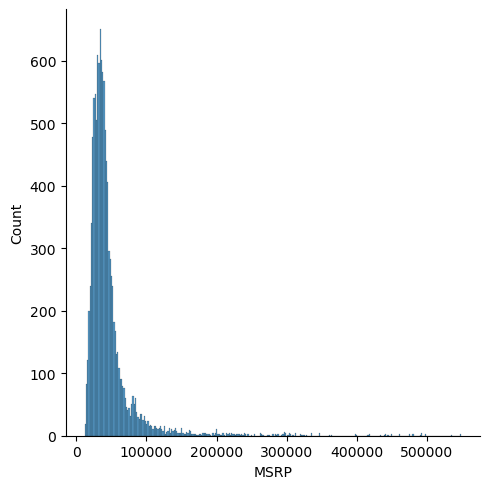

In [16]:
sns.displot(df.MSRP)

The distribution of `MSRP` is skewed to right, which is a problem for certain kinds of models (such as Lasso Regression), so for the modelling, I will take `log` to make it close to normal distribution.

Below are the relationships between numerical variables and `MSRP`.

It is obvious that `Base Curb Weight (lbs)`, `Width, Max w/o mirrors (in)`, and `EPA Fuel Economy Est - City (MPG)` have correlations with `MSRP`, the first two have the positive one while the latter has the negative one. Besides, as `Width, Max w/o mirrors (in)` increases, the values of `MSRP` spread out, on the other hand, as `EPA Fuel Economy Est - City (MPG)` increases, the values of `MSRP` spread out. In fact, this is a common effect in this dataset, I think it is because some specs are more popular, many manufacturers produce cars based on similar models (with similar specs), but they have different pricing strategies, making the tendency spread out. A good example is the plot of `MSRP` against `Passenger Capacity`, the most common specs (from 2 to 5 seats) have the most diverse prices. I believe that is the reason resulting for the negative relationship between `EPA Fuel Economy Est - City (MPG)` and `MSRP`, at first it is counterintuitive since it means that the more fuel-efficient car is cheaper, but if taking the reasoning above into account, it would make sense.

[4] EPA Fuel Economy Est - City (MPG): https://fueleconomy.gov/feg/label/learn-more-gasoline-label.shtml

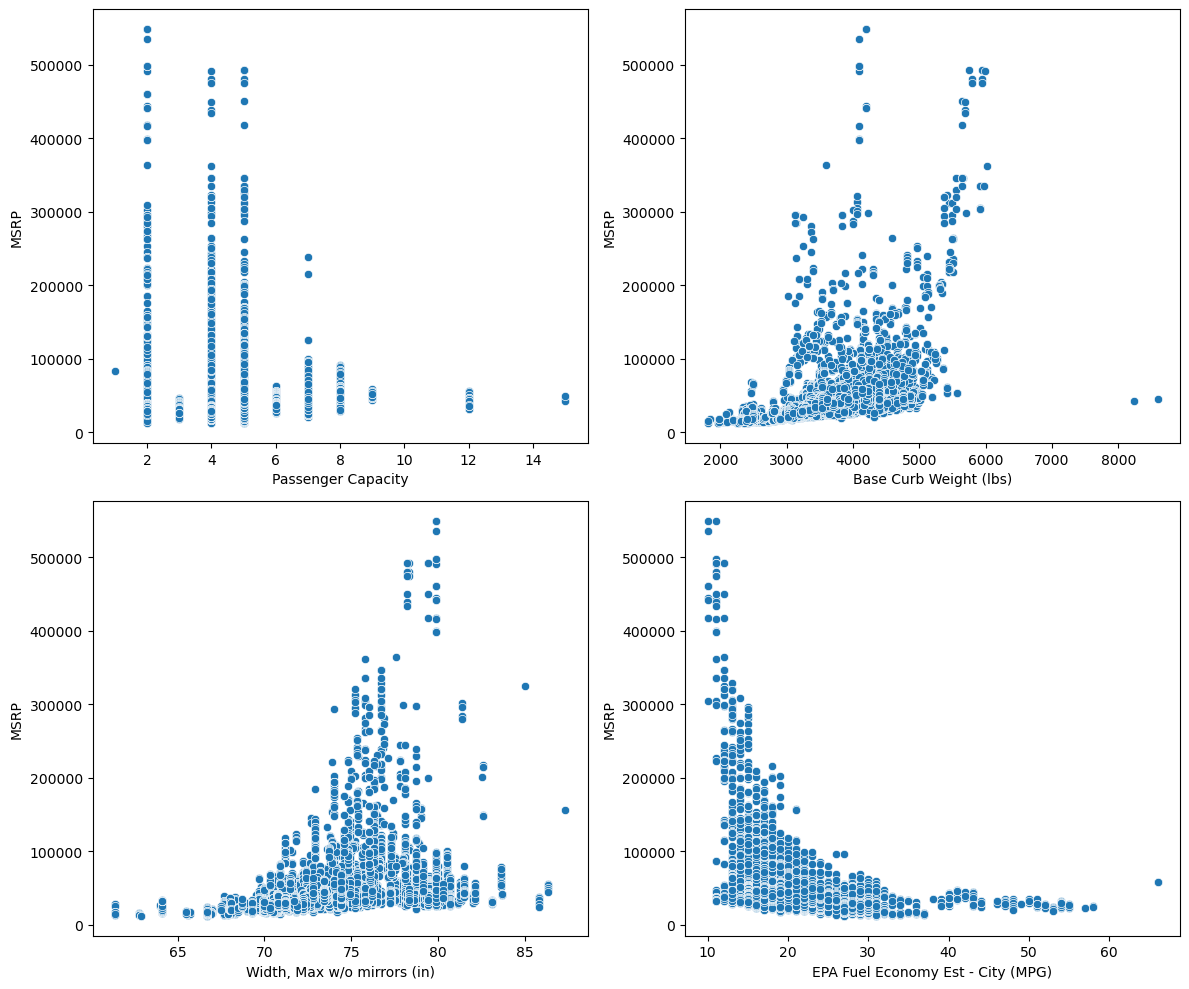

In [17]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

sns.scatterplot(x='Passenger Capacity', y='MSRP', data=df1, ax=ax[0,0])
sns.scatterplot(x='Base Curb Weight (lbs)', y='MSRP', data=df1, ax=ax[0,1])
sns.scatterplot(x='Width, Max w/o mirrors (in)', y='MSRP', data=df1, ax=ax[1,0]) # spread out
sns.scatterplot(x='EPA Fuel Economy Est - City (MPG)', y='MSRP', data=df1, ax=ax[1,1]) # shrink, lower is more eco-friendly

plt.tight_layout()

In the plot here, there are positive relationships between `MSRP` and `Net Horsepower`, `Net Torque`, `Displacement (cc)`, and `Rear Wheel Size`, and also as the values increase, the price spread out, reflecting the diverse pricing strategies in the market. One thing interesting is that the relationships between `MSRP` and `Net Horsepower RPM` and `Net Torque RPM` are not obvious even though the clear relationships between `MSRP` and `Net Horsepower` and `Net Torque`.

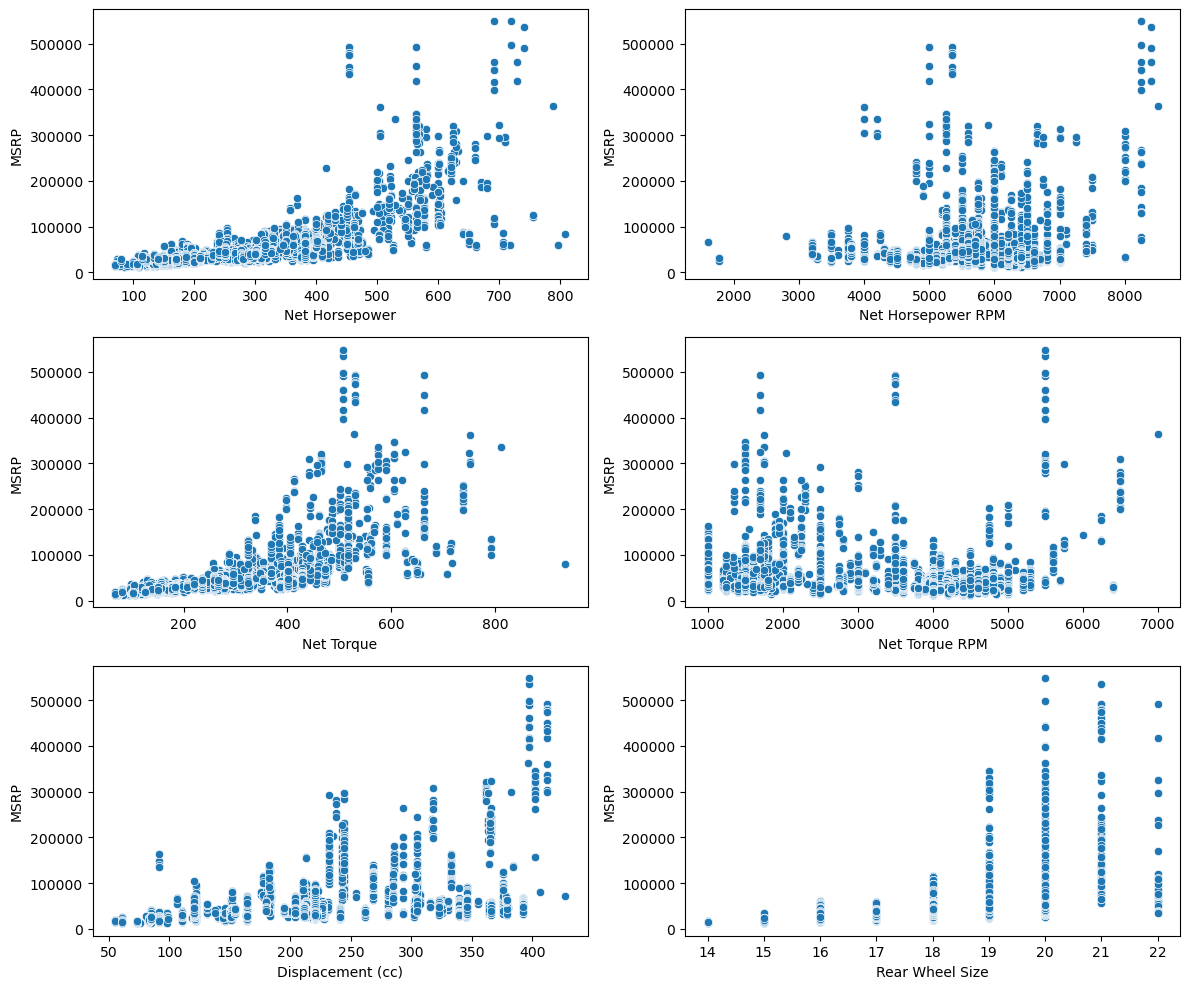

In [18]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

sns.scatterplot(x='Net Horsepower', y='MSRP', data=df1, ax=ax[0,0])
sns.scatterplot(x='Net Horsepower RPM', y='MSRP', data=df1, ax=ax[0,1])
sns.scatterplot(x='Net Torque', y='MSRP', data=df1, ax=ax[1,0])
sns.scatterplot(x='Net Torque RPM', y='MSRP', data=df1, ax=ax[1,1])
sns.scatterplot(x='Displacement (cc)', y='MSRP', data=df1, ax=ax[2,0])
sns.scatterplot(x='Rear Wheel Size', y='MSRP', data=df1, ax=ax[2,1])

plt.tight_layout()

As for the categorical variables, `Fuel System`, `Steering Type`, `Suspension Type - Front`, `Child Safety Rear Door Locks` don't have a huge impact on the price. `Night Vision` can help distinguish two price levels well. Besides, `Year` doesn't have a big effect on the price, but there are a lot of outliers (whose prices are much more higher compared to the average car value) every year.

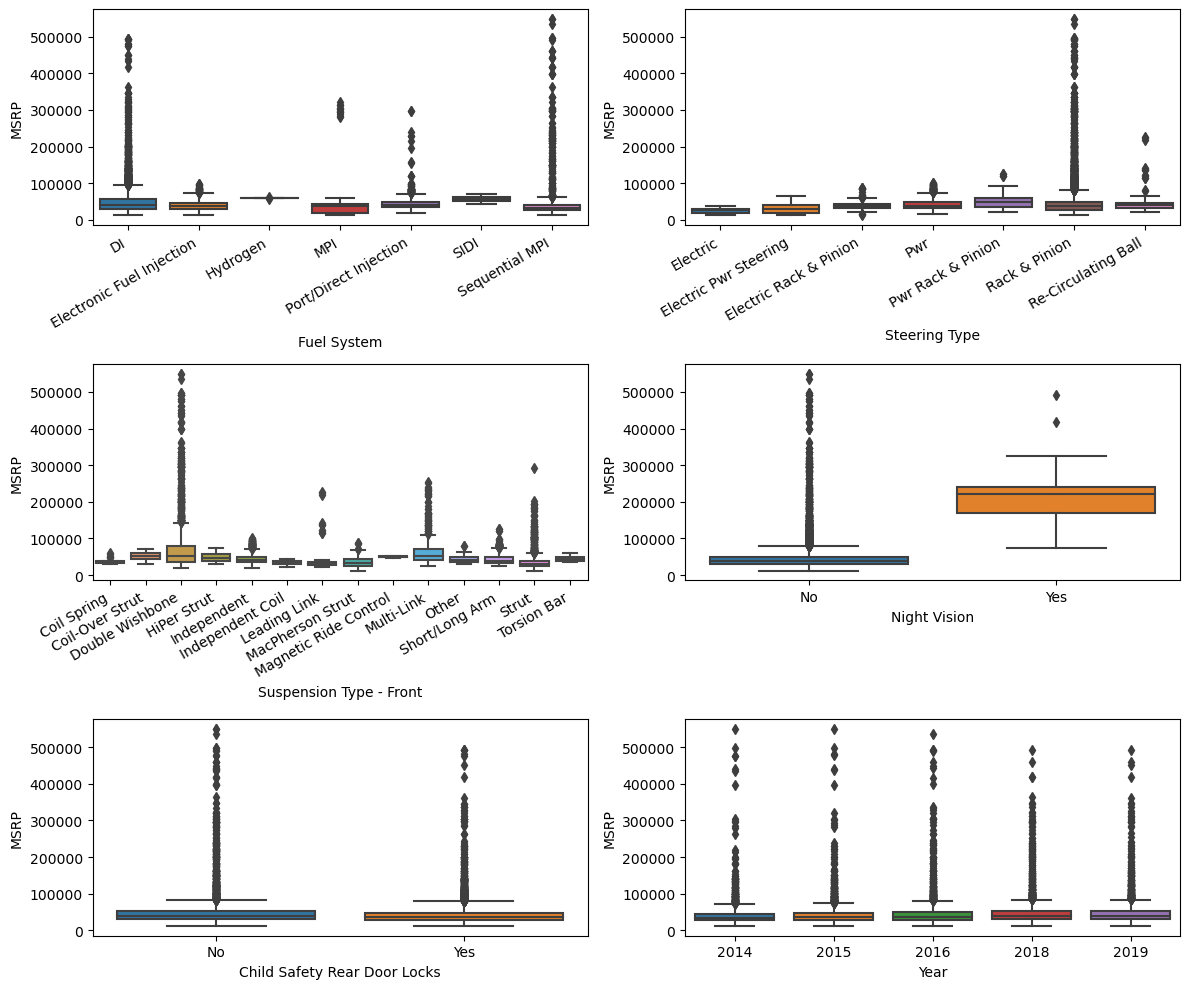

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(12,10))

sns.boxplot(x='Fuel System', y='MSRP', data=df1, ax=ax[0,0])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=30, horizontalalignment='right')

sns.boxplot(x='Steering Type', y='MSRP', data=df1, ax=ax[0,1])
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, horizontalalignment='right')

sns.boxplot(x='Suspension Type - Front', y='MSRP', data=df1, ax=ax[1,0])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30, horizontalalignment='right')

sns.boxplot(x='Night Vision', y='MSRP', data=df1, ax=ax[1,1])

sns.boxplot(x='Child Safety Rear Door Locks', y='MSRP', data=df1, ax=ax[2,0])

sns.boxplot(x='Year', y='MSRP', data=df1, ax=ax[2,1])

plt.tight_layout()

## 4. Feature Engineering

In this part, I will transform the response variable `MSRP` to `log` scale for better performance mentioned in the last section. In addition, I will create dummy variables for the categorical variables and impute the NA data. In this case, I will use KNN Imputation because compared to univariate imputations, multivariate imputations (one of them is KNN Imputation) can give us more reliable results. Last, I will split the data into three parts, training data, validating data, and testing data.

> Assumption:
>
> The result of imputation is robust.

In [20]:
df_y = np.log(df1['MSRP'].values) # to log scale
df_X = df1.drop(['MSRP'], axis=1) # drop the response variable

In [21]:
df_X1 = pd.get_dummies(df_X, drop_first=True) # create dummy variables

In [22]:
# impute the data
ki = KNNImputer()
df_X2 = ki.fit_transform(df_X1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_X2, df_y, test_size=0.2, random_state=0)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## 5. Model Fitting

As mentioned in Introduction, I focused on the regression models with high interpretability, hence I chose two base models, Random Forest (the attribute `feature_importances_` can shed light on the importance of variables) and Lasso Regression (the coefficients are easy to interpret and have direct relationships with the response variable). Based on the performance of both models, I will select the promising one (which yields good results) to conduct hyperparameter tuning. The metrics I use to evaluate a model are $R^2$ and mean square error.

### Base Model

#### Random Forest

In [25]:
rfr = RandomForestRegressor(random_state=0, oob_score=True, max_depth=10)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, oob_score=True, random_state=0)

In [26]:
rfr.oob_score_ # similar to perform validating data evaluation

0.9690291323286678

In [27]:
rfr.score(X_val, y_val) # evaluate the validating data, the score is R^2

0.9667388795329083

In [28]:
prv_rfr = rfr.predict(X_val)

In [29]:
mean_squared_error(np.exp(y_val), np.exp(prv_rfr))

49673012.70372245

#### Lasso Regression

In [30]:
# the prediction would be influenced by the scale of the data
# so standardise the data first
ss_t = StandardScaler()
X_train1 = ss_t.fit_transform(X_train)

ss_v = StandardScaler()
X_val1 = ss_v.fit_transform(X_val)

lcv = LassoCV(random_state=0)

In [31]:
lcv.fit(X_train1, y_train)

LassoCV(random_state=0)

In [32]:
lcv.score(X_val1, y_val)

0.9092975402324828

In [33]:
prv_lcv = lcv.predict(X_val1)

In [34]:
mean_squared_error(np.exp(y_val), np.exp(prv_lcv))

331891506.4314619

Without any tuning, Random Forest can produce far better results than Lasso Regression in terms of $R^2$ (validation score: 0.97 vs. 0.91, higher is better) and mean square error (validation score: 49,673,013 vs. 331,891,506, lower is better). Hence I will perform hyperparameter tuning with Random Forest. 

In the regression setting, $R^2$=0.97 means that the model can explain 97% of the variation in the data, which is very impressive.

### Hyperparameter Tuning

Here I only tuned two hyperparameters, the higher `n_estimators` the better prediction results in general, but the execution time increases as well. Also, the higher `max_depth` the better training results, but the risk of overfitting increases. I wanted to find a balance between performance, efficiency, and prediction results. I used grid search to find the optimal hyperparameter combination, and I set the optimising goal as maximising the negative mean squared error, in other words, minimising the error between the true values and the predictions.

In [35]:
params = {'n_estimators': [100, 200, 500], 'max_depth': [10, 20, 50]}

rfr_cv = RandomForestRegressor(random_state=0)

rcv = GridSearchCV(rfr_cv, params, scoring='neg_mean_squared_error')

In [36]:
rcv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [10, 20, 50],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error')

In [37]:
rcv.cv_results_

{'mean_fit_time': array([ 4.05610347,  8.13415661, 20.52457228,  5.88805552, 11.80272198,
        29.48838754,  5.9528791 , 11.92955709, 29.8038928 ]),
 'std_fit_time': array([0.01140795, 0.04617566, 0.09144335, 0.02630871, 0.05599207,
        0.11618434, 0.0307536 , 0.05699375, 0.13162822]),
 'mean_score_time': array([0.0132431 , 0.02608342, 0.06522727, 0.02303605, 0.04575744,
        0.1153038 , 0.02333207, 0.0464057 , 0.11484265]),
 'std_score_time': array([1.64783056e-04, 3.36734872e-04, 5.93533694e-04, 1.26511593e-04,
        3.17737663e-04, 1.50800688e-03, 3.96943378e-05, 4.08662815e-04,
        4.44492038e-04]),
 'param_max_depth': masked_array(data=[10, 10, 10, 20, 20, 20, 50, 50, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 500, 100, 200, 500, 100, 200, 500],
              mask=[False, False, False, False, False

Given the hyperparameter set, I chose to use `n_estimators`=200 instead of `n_estimators`=500 because the improvement is small but the execution time is longer. Based on the results, `mean_test_score` doesn't increase as `max_depth` increases, indicating that there is no overfitting, I want to exploit the effect of `max_depth`, so I will keep tuning `max_depth` with `n_estimators`=200.

In [38]:
params = {'max_depth': [50, 100, 200, 500]}

rfr_cv = RandomForestRegressor(random_state=0, n_estimators=200)

rcv = GridSearchCV(rfr_cv, params, scoring='neg_mean_squared_error')

In [39]:
rcv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_estimators=200, random_state=0),
             param_grid={'max_depth': [50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [40]:
rcv.cv_results_

{'mean_fit_time': array([11.93296399, 11.92554393, 11.92737479, 11.92506742]),
 'std_fit_time': array([0.06414429, 0.05914625, 0.06037283, 0.06245704]),
 'mean_score_time': array([0.04698405, 0.04679074, 0.04643726, 0.04629598]),
 'std_score_time': array([0.00070802, 0.00045149, 0.00053679, 0.00030073]),
 'param_max_depth': masked_array(data=[50, 100, 200, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 50},
  {'max_depth': 100},
  {'max_depth': 200},
  {'max_depth': 500}],
 'split0_test_score': array([-0.00527522, -0.00527522, -0.00527522, -0.00527522]),
 'split1_test_score': array([-0.00525767, -0.00525767, -0.00525767, -0.00525767]),
 'split2_test_score': array([-0.00565151, -0.00565151, -0.00565151, -0.00565151]),
 'split3_test_score': array([-0.00448214, -0.00448214, -0.00448214, -0.00448214]),
 'split4_test_score': array([-0.00665283, -0.00665283, -0.00665283, -0.00665283]),
 'mean_test_score': a

Given the `max_depth` set, they have identical `mean_test_score`, considering parsimony, I chose `max_depth` as 50.

In conclusion, my final model is Random Forest with `n_estimators`=200 and `max_depth`=50.

## 6. Model Results and Validation

Now I have the final model, I am going to use whole data to train the model and interpret the results.

In [41]:
rfr_complete = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=50, oob_score=True)
rfr_complete.fit(df_X2, df_y)

RandomForestRegressor(max_depth=50, n_estimators=200, oob_score=True,
                      random_state=0)

In [42]:
rfr_complete.oob_score_

0.9869649903141244

OOB score functions as the validation score, in this case, the model can explain 99% of the variation in the data, indicating the model fit is great.

In [43]:
pr_rfr = rfr_complete.predict(df_X2)

In [44]:
# in this setting, positive values represent cars are overpriced, and vice versa
err = np.exp(df_y) - np.exp(pr_rfr)

Text(0, 0.5, 'Count')

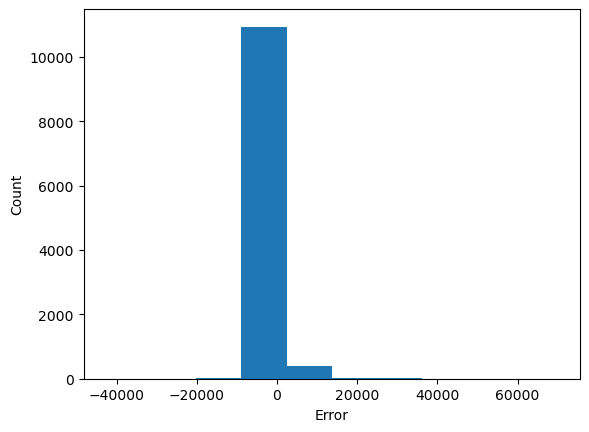

In [45]:
plt.hist(err)
plt.xlabel('Error')
plt.ylabel('Count')

Based on the histogram above, most predictions' error is around 0, indicating a good model fit. The distribution is slightly skewed to right representing that the model tends to underestimate the retail price (the model thinks more cars are overpriced than underpriced).

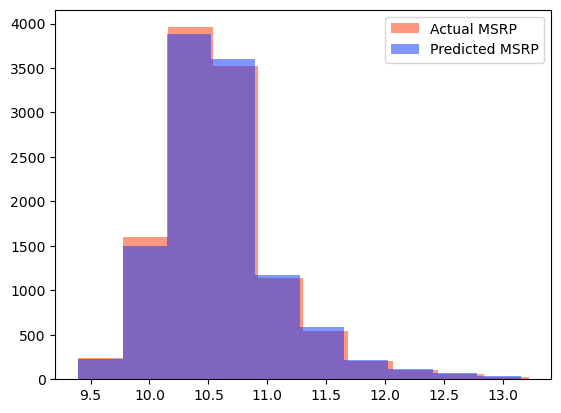

In [46]:
plt.hist(df_y, label='Actual MSRP', color=(1,0.2,0,0.5))
plt.hist(pr_rfr, label='Predicted MSRP', color=(0,0.2,1,0.5))
plt.legend()

From the histogram above, the distributions for actual prices and predicted prices are similar, indicating that the model produced prices similar to the original one. Now, it is necessary to check whether these values matched the original data.

Text(0, 0.5, 'Predicted MSRP')

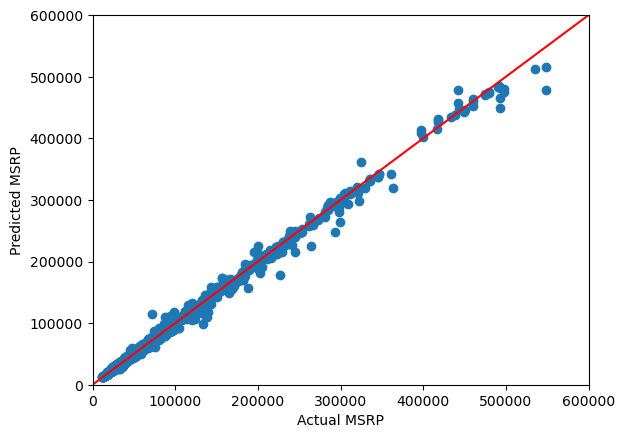

In [47]:
plt.scatter(np.exp(df_y), np.exp(pr_rfr))
plt.plot([0,600000], [0,600000], c='red')
plt.xlim(0, 600000)
plt.ylim(0, 600000)
plt.xlabel('Actual MSRP')
plt.ylabel('Predicted MSRP')

The red line indicates the perfect prediction, all prediction values are identical to the actual values. From the plot, most predictions are aligned with the red line. It is worth noting that as the retail prices increase, the errors are slightly spread out due to the limited sample size. In fact, the one with the highest error is the one with a high retail price. I will check on this sample later.

Now I will interpret the model based on the feature importance. I will select the factors with importance > 1%  as the most important factors driving the cars' retail prices.

In [48]:
rfr_importance = pd.DataFrame({'Feature': df_X1.columns, 
                               'Importance': rfr_complete.feature_importances_}).sort_values('Importance',
                                                                        ascending=False).head(6) # importance>0.01

In [49]:
rfr_importance

,Feature,Importance
32,Net Horsepower,0.494027
34,Net Torque,0.232019
2,Base Curb Weight (lbs),0.031721
127,Parking Aid_Yes,0.031376
37,Displacement (cc),0.027526
42,Tire Width Ratio,0.010733


`Net Horsepower` and `Net Torque` are the two most important factors determining the prices, which makes sense because they are closely related to the overall performance of a car, and from the Data Visualisation section, we've seen that these two variables have positive correlations with the price. Also, `Base Curb Weight (lbs)`, `Displacement (cc)`, and `Tire Width Ratio` have positive relationships with the price. For `Base Curb Weight (lbs)` I think it is because as weight increases, the cost of material increases, and for `Displacement (cc)`, it is related to the overall performance. Last, for `Tire Width Ratio`, from the plot below, we can find that the cars with greater tire width ratio are more expensive, that is the reason it is one of the most important factors. These variables need to be further studied.

In the data visualisation section, we've seen that `Night Vision` can help distinguish different price levels, however, it is not considered one of the most important factors, I think it is because the continuous variables can provide more concrete price estimation. But categorical variables do provide some information to the prediction, hence we can see that `Parking Aid_Yes` is one of the important factors in the model. From the plot below, `Parking Aid` can help distinguish the price levels around 50000, which contains lots of data points there. As a result, `Parking Aid` is more useful to predict the price than `Night Vision`, which does the job well at the price levels where continuous variables such as `Net Horsepower` and `Net Torque` can yield good results as well.

[5] Curb Weight: https://www.ford.com/support/how-tos/owner-resources/vehicle-specifications/what-is-the-curb-weight-of-my-vehicle/

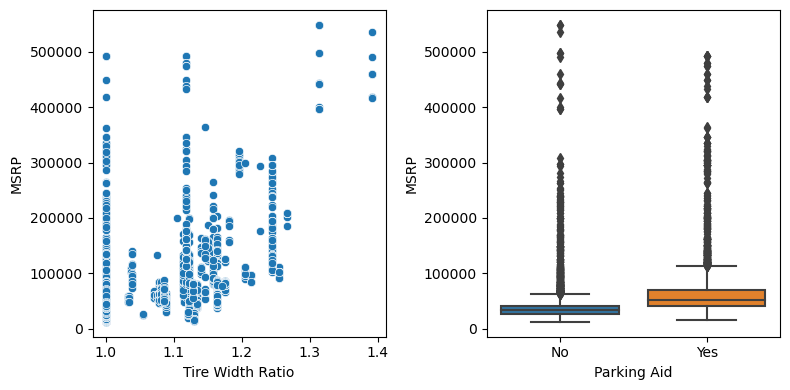

In [90]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

sns.scatterplot(x='Tire Width Ratio', y='MSRP', data=df1, ax=ax[0])
sns.boxplot(x='Parking Aid', y='MSRP', data=df1, ax=ax[1])

plt.tight_layout()

## 7. Model Interpretation (Case Study)

Now I will investigate some cases. First is the one with the greatest error.

In [52]:
# add some prediction-related columns to the dataframe, add Car_Make_Model_Style for better recognition
df_pr = df_X1.copy()
df_pr['Car_Make_Model_Style'] = df.dropna(subset=to_drop_na, axis=0).Car_Make_Model_Style
df_pr['Error'] = err
df_pr['Abs_Error'] = np.abs(df_pr.Error)
df_pr['MSRP'] = np.exp(df_y)
df_pr['Predicted MSRP'] = np.exp(pr_rfr)

In [53]:
# only select the most important features and some auxiliary columns
col_sel = list(rfr_importance.Feature) + ['Error', 'Abs_Error', 'MSRP', 'Predicted MSRP', 'Car_Make_Model_Style']

In [54]:
# find the record with the greatest error
df_pr.loc[:,col_sel].sort_values('Abs_Error', ascending=False).head(20)

,Net Horsepower,Net Torque,Base Curb Weight (lbs),Parking Aid_Yes,Displacement (cc),Tire Width Ratio,Error,Abs_Error,MSRP,Predicted MSRP,Car_Make_Model_Style
6426,691.0,508.0,4196.0,0,397.0,1.313725,69871.548851,69871.548851,548800.0,478928.451149,2014 Lamborghini Aventador Specs: 2-Door Conve...
7283,416.0,450.0,NaN,0,243.0,1.000000,48376.929713,48376.929713,227300.0,178923.070287,2018 Mercedes-Benz G Class Specs: G 550 4x4 Sq...
2859,788.0,529.0,3593.0,1,396.0,1.145455,45123.273840,45123.273840,363730.0,318606.726160,2018 Ferrari 812 Superfast Specs: Coupe
8770,700.0,553.0,3241.0,0,232.0,1.226415,44757.093866,44757.093866,293200.0,248442.906134,2018 Porsche 911 Specs: GT2 RS Coupe
9563,563.0,664.0,NaN,1,412.0,1.000000,42689.942535,42689.942535,492425.0,449735.057465,2018 Rolls-Royce Phantom Specs: Extended Wheel...
2016,505.0,481.0,3820.0,0,427.0,1.000000,-42620.988290,42620.988290,72305.0,114925.988290,2015 Chevrolet Camaro Specs: 2-Door Coupe Z/28
8735,570.0,553.0,4586.0,1,293.0,1.156863,38578.245981,38578.245981,263900.0,225321.754019,2016 Porsche Panamera Specs: 4-Door HB Exclusi...
6423,691.0,508.0,4196.0,0,397.0,1.313725,-37328.451149,37328.451149,441600.0,478928.451149,2014 Lamborghini Aventador Specs: 2-Door Conve...
9560,563.0,627.0,NaN,1,412.0,1.117647,-36579.487250,36579.487250,325000.0,361579.487250,2019 Rolls-Royce Cullinan Specs: Sport Utility
992,493.0,442.0,3329.0,1,182.0,1.075472,35331.137433,35331.137433,133205.0,97873.862567,2016 BMW M4 Specs: 2-Door Coupe GTS


In [55]:
# compare the difference between the car 6422 and 6426
for i in df_pr.loc[[6422,6426],:].dropna(axis=1).columns:
    if df_pr.loc[6422, i] != df_pr.loc[6426, i]:
        print(i, df_pr.loc[6422, i], df_pr.loc[6426, i])

EPA Fuel Economy Est - City (MPG) 10.0 11.0
Net Horsepower 720.0 691.0
Year_2015 1 0
Car_Make_Model_Style 2015 Lamborghini Aventador Specs: 2-Door Convertible 50th Anniversario 2014 Lamborghini Aventador Specs: 2-Door Convertible 50th Anniversario
Error 32799.23922052013 69871.54885063076
Abs_Error 32799.23922052013 69871.54885063076
Predicted MSRP 516000.7607794795 478928.4511493689


The one with the greatest error is the row index 6426 (2014 Lamborghini Aventador Specs: 2-Door Convertible 50th Anniversario). Here we can find something interesting, the row index 6426 and 6422 (2015 Lamborghini Aventador Specs: 2-Door Convertible 50th Anniversario) are from the same brand Lamborghini and have the same price, but they have different predicted prices, the latter has a higher price. From the comparison above, the car 6422 has higher net horsepower and is newer but less fuel-efficient slightly. Looking at the car names, we can find that the car 6422 is the newer version of the same model, hence the price is the same but has better specs. That's the reason why the car 6426 is overpriced a lot because it is worse than the car 6422 from the perspective of specs, and the model doesn't give year a higher weight and doesn't consider the model names.

Another interesting thing related to the row index 6426 is that there is another car, the row index 6423 (2014 Lamborghini Aventador Specs: 2-Door Convertible) has identical specs but the price is much lower, making the model overestimate the price for this car. From the names, we can find that the car 6426 is the 50th Anniversario version of the car 6423, that is where the extra value comes from. The model doesn't take this into account (my assumption is to focus on the technical specs only), so it thinks that the car 6426 is overpriced and the car 6423 is underpriced.

In [56]:
# compare the difference between the car 6423 and 6426
for i in df_pr.loc[[6423,6426],:].dropna(axis=1).columns:
    if df_pr.loc[6423, i] != df_pr.loc[6426, i]:
        print(i, df_pr.loc[6423, i], df_pr.loc[6426, i])

Car_Make_Model_Style 2014 Lamborghini Aventador Specs: 2-Door Convertible 2014 Lamborghini Aventador Specs: 2-Door Convertible 50th Anniversario
Error -37328.45114936872 69871.54885063076
Abs_Error 37328.45114936872 69871.54885063076
MSRP 441600.0000000002 548799.9999999997


One way to interpret the predictions from the model is to compare the specs of the car with the cars with similar actual prices and with the cars with prices that are close to the prediction values. In this way, we can know why the cars are over/underpriced.

To do this comparison, I constructed the function below.

In [57]:
def compare(idx, error_range=10000, print_true=False, print_predicted=False):
    '''
    Compare the specs of the car with the cars with similar actual prices 
    and with the cars with prices close to the prediction values.
    
    In this case, the specs considered are the important factors determined by the model.
    
    The function will print whether the specs of the target car are similar to those of the cars with
    similar actual prices, and whether they are similar to the cars with prices 
    close to the prediction values using the range of the given specs.
    
    Besides, the function can print the summarised table (mean, median, min, max) of the specs.
    
    Input:
        idx(int): the target car index
        error_range(float, default=10000): the range of price would be considered for the "similar" prices
        print_true(bool, default=False): print the summarised table of the specs 
            from the cars with similar actual prices
        print_predicted(bool, default=False): print the summarised table of the specs 
            from the cars with prices close to the prediction values
            
    Output:
        None
    '''
    t_MSRP = df_pr.loc[idx,'MSRP'] # true price for the target car
    p_MSRP = df_pr.loc[idx,'Predicted MSRP'] # predicted price for the target car
    
    # get the specs of the target car
    target = df_pr.loc[idx, list(rfr_importance.Feature)]
    
    # get the summarised table of the cars with similar actual prices (within the error_range)
    # also drop the target car data from the table
    t_df_pr = df_pr.loc[(df_pr.MSRP<=t_MSRP + error_range)&(df_pr.MSRP>=t_MSRP - error_range),
                        col_sel].drop(idx).describe().loc[['mean','50%', 'min', 'max'],
                                                list(rfr_importance.Feature)].transpose()\
                                                .rename(columns={'mean':'Mean',
                                                                 '50%':'Median',
                                                                 'min':'Min',
                                                                 'max':'Max'})
    
    # get the summarised table of the cars with prices close to the prediction values (within the error_range)
    p_df_pr = df_pr.loc[(df_pr.MSRP<=p_MSRP + error_range)&(df_pr.MSRP>=p_MSRP - error_range),
                        col_sel].describe().loc[['mean','50%', 'min', 'max'],
                                                list(rfr_importance.Feature)].transpose()\
                                                .rename(columns={'mean':'Mean',
                                                                 '50%':'Median',
                                                                 'min':'Min',
                                                                 'max':'Max'})
    
    # check whether the specs of the target car are similar to those of the cars with similar actual prices
    in_true = [(target[i]>=t_df_pr.loc[i,'Min']) and (target[i]<=t_df_pr.loc[i,'Max']) 
               for i in list(rfr_importance.Feature)]
    
    # check whether they are similar to the cars with prices close to the prediction values
    in_predicted = [(target[i]>=p_df_pr.loc[i,'Min']) and (target[i]<=p_df_pr.loc[i,'Max']) 
               for i in list(rfr_importance.Feature)]
    
    # print the similarity of the specs
    print(pd.DataFrame({'Target': df_pr.loc[idx,list(rfr_importance.Feature)], 
                        'In true value': in_true, 'In predicted value': in_predicted}))
    
    # print the summarised table
    if print_true:
        print('\nSummary table for the data within the range of true MSRP')
        print(t_df_pr)
        
    if print_predicted:
        print('\nSummary table for the data within the range of predicted MSRP')
        print(p_df_pr)

Now I will investigate the case with the highest bias rate, the ratio of error to actual price is highest, using the function above.

In [58]:
df_pr['Bias_rate'] = df_pr.Error/df_pr.MSRP # calculate the bias rate

In [59]:
# select useful columns
col_sel1 = list(rfr_importance.Feature) + ['Error', 'Abs_Error', 'MSRP', 'Predicted MSRP',
                                           'Car_Make_Model_Style', 'Bias_rate']

In [60]:
# select the bias rate >= 20%
df_pr.loc[np.abs(df_pr.Bias_rate)>=0.2,col_sel1].sort_values('Bias_rate', ascending=False)

,Net Horsepower,Net Torque,Base Curb Weight (lbs),Parking Aid_Yes,Displacement (cc),Tire Width Ratio,Error,Abs_Error,MSRP,Predicted MSRP,Car_Make_Model_Style,Bias_rate
992,493.0,442.0,3329.0,1,182.0,1.075472,35331.137433,35331.137433,133205.0,97873.862567,2016 BMW M4 Specs: 2-Door Coupe GTS,0.265239
5963,285.0,260.0,NaN,0,220.0,1.000000,7140.875004,7140.875004,33195.0,26054.124996,2016 Jeep Wrangler Specs: 4WD 2-Door Rubicon H...,0.215119
7283,416.0,450.0,NaN,0,243.0,1.000000,48376.929713,48376.929713,227300.0,178923.070287,2018 Mercedes-Benz G Class Specs: G 550 4x4 Sq...,0.212833
9856,NaN,NaN,NaN,1,NaN,1.037736,28022.120853,28022.120853,138000.0,109977.879147,2019 Tesla Model X Specs: P100D AWD,0.203059
3175,411.0,434.0,NaN,1,380.0,1.000000,-11548.621161,11548.621161,47895.0,59443.621161,"2014 Ford F-150 Specs: 4WD SuperCrew 145"" SVT ...",-0.241124
9852,NaN,NaN,NaN,1,NaN,1.037736,-21977.879147,21977.879147,88000.0,109977.879147,2019 Tesla Model X Specs: AWD,-0.249749
3191,411.0,434.0,NaN,1,380.0,1.000000,-11659.467544,11659.467544,44995.0,56654.467544,"2014 Ford F-150 Specs: 4WD SuperCab 133"" SVT R...",-0.259128
2016,505.0,481.0,3820.0,0,427.0,1.000000,-42620.988290,42620.988290,72305.0,114925.988290,2015 Chevrolet Camaro Specs: 2-Door Coupe Z/28,-0.589461


Based on the table above, in terms of bias rate, the car 992 (2016 BMW M4 Specs: 2-Door Coupe GTS) has the highest positive bias rate, and the car 2016 (2015 Chevrolet Camaro Specs: 2-Door Coupe Z/28) has the highest negative one.

In [61]:
compare(992, error_range=17000, print_true=True, print_predicted=True)

                          Target  In true value  In predicted value
Net Horsepower             493.0           True                True
Net Torque                 442.0           True                True
Base Curb Weight (lbs)    3329.0           True                True
Parking Aid_Yes                1           True                True
Displacement (cc)          182.0           True                True
Tire Width Ratio        1.075472           True                True

Summary table for the data within the range of true MSRP
                               Mean       Median     Min          Max
Net Horsepower           511.096154   518.000000   357.0   755.000000
Net Torque               489.534591   500.000000   325.0   792.000000
Base Curb Weight (lbs)  4132.472868  4189.000000  3108.0  5115.000000
Parking Aid_Yes            0.743902     1.000000     0.0     1.000000
Displacement (cc)        263.374194   268.000000    91.0   384.000000
Tire Width Ratio           1.122139     1.1224

For the case the car 992, the specs are within both the ranges of true prices and the ranges of predicted prices. Comparing the target car with the median values of the specs (to reduce the effect of extreme values), even though `Net Horsepower` is close to those of cars within the same retail price range, `Net Torque` is much closer to those of cars within the predicted price range, which is far lower than the price within the same retail price range, so it is one of the most overpriced cars.

In [62]:
compare(2016, error_range=20000, print_true=True, print_predicted=True)

                        Target  In true value  In predicted value
Net Horsepower           505.0           True                True
Net Torque               481.0           True                True
Base Curb Weight (lbs)  3820.0           True                True
Parking Aid_Yes              0           True                True
Displacement (cc)        427.0          False               False
Tire Width Ratio           1.0           True                True

Summary table for the data within the range of true MSRP
                               Mean  Median     Min          Max
Net Horsepower           369.316062   362.0   151.0   808.000000
Net Torque               384.327157   383.0   243.0   935.000000
Base Curb Weight (lbs)  4106.615865  4123.0  2465.0  5567.000000
Parking Aid_Yes            0.745132     1.0     0.0     1.000000
Displacement (cc)        242.827918   213.0   106.0   406.000000
Tire Width Ratio           1.032428     1.0     1.0     1.255319

Summary table for the da

For the case of the car 2016, we can find that in terms of the median, most of the important specs are similar to the cars in the predicted price range, especially for `Net Horsepower` and `Net Torque`. Because it has higher `Net Horsepower` and `Net Torque`, it is one of the most underpriced cars.

## 8. One Step Further (Brand Effects)

In this part, I will take brands into consideration. Instead of using all the brands, I used two categories, common car and luxury car, to represent the effect of brands, to simplify the analysis.

[6] Luxury car brands: https://luxe.digital/business/digital-luxury-ranking/best-luxury-car-brands/

In [63]:
# extract the brand names
brand = df.dropna(subset=to_drop_na, axis=0).Car_Make_Model_Style.apply(lambda x: x.split(' ')[1])

In [64]:
# classify the brands
common_car = ['Acura', 'Alfa', 'Bentley', 'Buick','Chevrolet', 'Chrysler', 'Dodge',  'FIAT', 'Ford', 
 'Genesis', 'GMC', 'Honda', 'Hyundai', 'INFINITI', 'Jeep', 'Kia', 'Lincoln', 'Lotus',
 'Maserati', 'Mazda', 'McLaren', 'MINI','Mitsubishi', 'Nissan', 'Ram',  'smart',
 'Subaru', 'Toyota', 'Volkswagen']
       
luxury_car = ['Mercedes-Benz', 'Tesla', 'BMW', 'Volvo', 'Audi', 'Porsche', 'Lexus','Lamborghini','Ferrari','Land',
'Cadillac','Jaguar','Rolls-Royce','Aston']

In [65]:
# create a list for the indicators of luxury brands
lux_list = [True if i in luxury_car else False for i in brand]

In [66]:
df_pr['Brand'] = brand
df_pr['Luxury'] = lux_list

<AxesSubplot:xlabel='Luxury', ylabel='MSRP'>

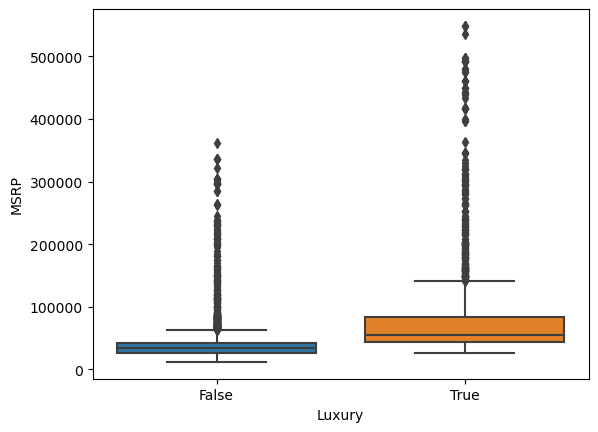

In [67]:
sns.boxplot(x='Luxury', y='MSRP', data=df_pr)

In [68]:
stats.f_oneway(df_pr['MSRP'][df_pr['Luxury'] == True].dropna(),
               df_pr['MSRP'][df_pr['Luxury'] == False].dropna())

F_onewayResult(statistic=2368.759447552976, pvalue=0.0)

From the plot above, we can know that luxury brands tend to have higher retail prices. And from the statistical testing ($H_0$: the mean values of prices for the two groups are the same, $H_1$: the mean values of prices for the two groups are different, p-value=0 < 0.05), we can know that the mean prices for the two groups are different. One thing that should keep in mind is that conclusion here only considers the brand itself, regardless of the technical specs.

Now looking at the prediction results, taking brands into consideration.

Text(0, 0.5, 'Predicted MSRP')

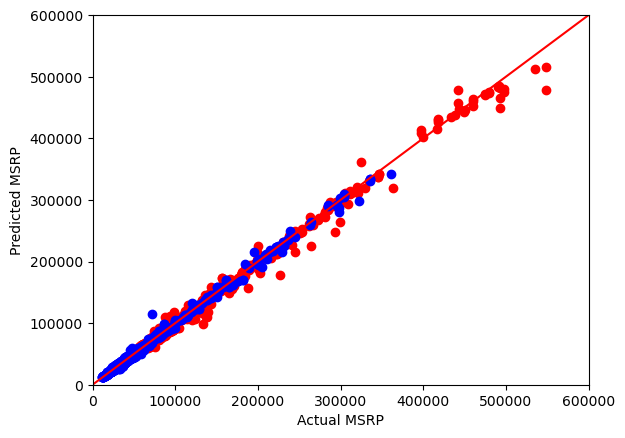

In [70]:
plt.scatter(np.exp(df_y[lux_list]), np.exp(pr_rfr[lux_list]), label='Luxury', c='r')
plt.scatter(np.exp(df_y[~np.array(lux_list)]), np.exp(pr_rfr[~np.array(lux_list)]), label='Common', c='b')
plt.plot([0,600000], [0,600000], c='red')
plt.xlim(0, 600000)
plt.ylim(0, 600000)
plt.xlabel('Actual MSRP')
plt.ylabel('Predicted MSRP')

From the plot above, it is obvious that luxury brands tend to have greater errors (away from the line). As a result, I wanted to build a model taking `Luxury` into account and see whether it can help the predictions.

In [71]:
# new dataset with Luxury
df_X3 = df_X1.copy()
df_X3['Luxury'] = lux_list

In [72]:
# impute again
ki = KNNImputer()
df_X4 = ki.fit_transform(df_X3)

In [73]:
# use the same hyperparameter
rfr_lux = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=50, oob_score=True)
rfr_lux.fit(df_X4, df_y)

RandomForestRegressor(max_depth=50, n_estimators=200, oob_score=True,
                      random_state=0)

In [74]:
pr_rfr_lux = rfr_lux.predict(df_X4)

In [75]:
# in this setting, positive values represent cars are overpriced, and vice versa
err_lux = np.exp(df_y) - np.exp(pr_rfr_lux)

Text(0, 0.5, 'Count')

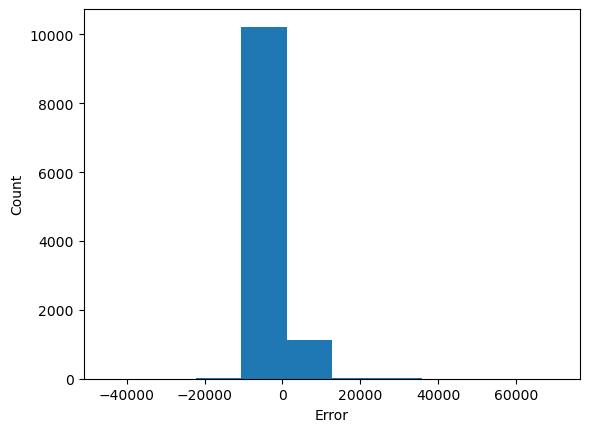

In [76]:
plt.hist(err_lux)
plt.xlabel('Error')
plt.ylabel('Count')

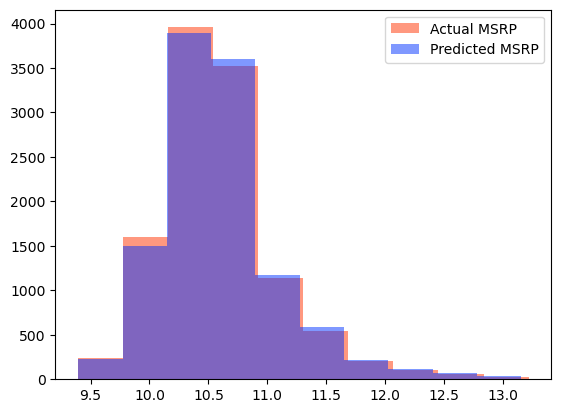

In [77]:
plt.hist(df_y, label='Actual MSRP', color=(1,0.2,0,0.5))
plt.hist(pr_rfr_lux, label='Predicted MSRP', color=(0,0.2,1,0.5))
plt.legend()

Text(0, 0.5, 'Predicted MSRP')

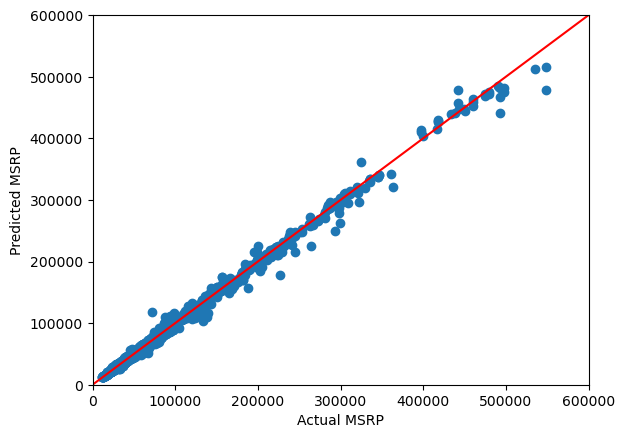

In [78]:
plt.scatter(np.exp(df_y), np.exp(pr_rfr_lux))
plt.plot([0,600000], [0,600000], c='red')
plt.xlim(0, 600000)
plt.ylim(0, 600000)
plt.xlabel('Actual MSRP')
plt.ylabel('Predicted MSRP')

In [79]:
rfr_lux.oob_score_

0.9871719040992101

In [80]:
# mean square error from the previous model
mean_squared_error(np.exp(df_y), np.exp(pr_rfr))

5237252.788383541

In [81]:
# mean square error from the model with Luxury
mean_squared_error(np.exp(df_y), np.exp(pr_rfr_lux))

5240606.727502266

From the histograms and the scatterplot above, the predictions don't change a lot. In fact, looking at the y-axis of the histogram, the OOB score of the model, and the mean square error (lower is better), this one is slightly worse than the model without `Luxury`. Now checking the feature importance and the predictions.

In [82]:
rfr_importance_lux = pd.DataFrame({'Feature': df_X3.columns, 
                               'Importance': rfr_lux.feature_importances_}).sort_values('Importance',
                                                                        ascending=False).head(7) # importance>0.01

In [83]:
rfr_importance_lux

,Feature,Importance
32,Net Horsepower,0.521685
34,Net Torque,0.211951
150,Luxury,0.048630
2,Base Curb Weight (lbs),0.030122
37,Displacement (cc),0.022740
127,Parking Aid_Yes,0.010895
42,Tire Width Ratio,0.010196


Compared to the previous model, `Luxury` is considered one of the important factors as well.

In [84]:
# add some prediction-related columns to the dataframe, add Car_Make_Model_Style for better recognition
df_pr_lux = df_X3.copy()
df_pr_lux['Error'] = err_lux
df_pr_lux['Abs_Error'] = np.abs(df_pr_lux.Error)
df_pr_lux['MSRP'] = np.exp(df_y)
df_pr_lux['Predicted MSRP'] = np.exp(pr_rfr_lux)

In [85]:
col_sel_lux = list(rfr_importance.Feature) + ['Error', 'Abs_Error', 'MSRP', 'Predicted MSRP', 'Luxury']

In [86]:
df_pr_lux.loc[:,col_sel_lux].sort_values('Abs_Error', ascending=False).head(5)

,Net Horsepower,Net Torque,Base Curb Weight (lbs),Parking Aid_Yes,Displacement (cc),Tire Width Ratio,Error,Abs_Error,MSRP,Predicted MSRP,Luxury
6426,691.0,508.0,4196.0,0,397.0,1.313725,70579.242403,70579.242403,548800.0,478220.757597,True
9563,563.0,664.0,NaN,1,412.0,1.000000,50701.141080,50701.141080,492425.0,441723.858920,True
7283,416.0,450.0,NaN,0,243.0,1.000000,49729.455453,49729.455453,227300.0,177570.544547,True
2016,505.0,481.0,3820.0,0,427.0,1.000000,-45264.098844,45264.098844,72305.0,117569.098844,False
8770,700.0,553.0,3241.0,0,232.0,1.226415,43175.520332,43175.520332,293200.0,250024.479668,True


Compared to common brands, luxury brands tend to overprice the car, however, even taking this into the model, the performance doesn't increase, and the cars with the greatest error don't change (though the order of top 5 with the greatest error changes). Hence it means that the original data can tell us whether the car belongs to the luxury group or not, specifically, we can use boxplot and ANOVA to check whether the means of `Net Horsepower` is different from two groups ($H_0$: the mean values of `Net Horsepower` for the two groups are the same, $H_1$: the mean values of `Net Horsepower` for the two groups are different).

<AxesSubplot:xlabel='Luxury', ylabel='Net Horsepower'>

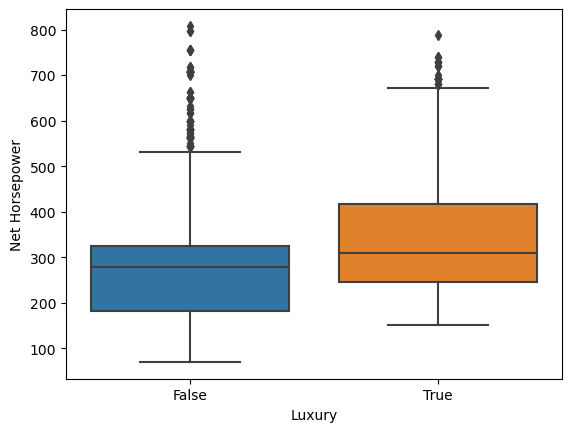

In [87]:
sns.boxplot(x='Luxury', y='Net Horsepower', data=df_pr)

In [88]:
stats.f_oneway(df_pr['Net Horsepower'][df_pr['Luxury'] == True].dropna(),
               df_pr['Net Horsepower'][df_pr['Luxury'] == False].dropna())

F_onewayResult(statistic=953.6004596409899, pvalue=3.851117771992792e-201)

From the result above, the p-value is close to 0 and smaller than 0.05, and the boxplot shows that the two groups have different distributions of `Net Horsepower`. In conclusion, the model can access the information of brands implicitly through other variables such as `Net Horsepower`.

## 9. Conclusion

Random Forest with `n_estimators`=200 and `max_depth`=50 can predict the retail prices very well, and the most important factors to determine the price are `Net Horsepower`, `Net Torque`, `Base Curb Weight (lbs)`, `Parking Aid_Yes`, `Displacement (cc)`, `Tire Width Ratio`. The higher the values of these specs (or equipped with certain functions), the higher the retail price.

Based on the model, the most overpriced car is 2014 Lamborghini Aventador Specs: 2-Door Convertible 50th Anniversario because compared to other cars within the same level, it has lower Net Horsepower. In terms of bias rate, the car 2016 BMW M4 Specs: 2-Door Coupe GTS is the most overpriced car because its `Net Torque` is far lower than the price within the same retail price range. And the car 2015 Chevrolet Camaro Specs: 2-Door Coupe Z/28 is the most underpriced car because it has higher `Net Horsepower` and `Net Torque` compared to cars on the same level.